<a href="https://colab.research.google.com/github/Nempickaxe/bert-classfier-huggingface/blob/main/BERT_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download complaints file
!wget -o /tmp/zipfile http://files.consumerfinance.gov/ccdb/complaints.csv.zip
!unzip complaints.csv.zip
!rm complaints.csv.zip
!ls

Archive:  complaints.csv.zip
  inflating: complaints.csv          
complaints.csv	sample_data


In [2]:
!pip install transformers

     |████████████████████████████████| 1.5MB 11.6MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
     |████████████████████████████████| 2.9MB 51.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=7400313278007b3ffd7e00fe661721a8372197ca4fa3725f336f3934444d6f35
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import BertConfig, BertTokenizerFast, TFBertModel

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [4]:
data = pd.read_csv('complaints.csv', usecols=['Consumer complaint narrative', 'Product', 'Issue']).sample(50000)
data.dropna(inplace=True)

In [5]:
data.shape

(16962, 3)

In [6]:
#filter issues with atleast a single count
data = data.groupby('Issue').filter(lambda x: len(x)>1)
data = data.groupby('Product').filter(lambda x: len(x)>1)

In [7]:
le_product = LabelEncoder()
le_issue = LabelEncoder()

data['Product_label'] = le_product.fit_transform(data['Product'])
data['Issue_label'] = le_issue.fit_transform(data['Issue'])

In [8]:
train_data, data_test = train_test_split(data, test_size = 0.2, stratify = data[['Issue_label']])
train_data.shape

(13559, 5)

In [9]:
data.head()

,Product,Issue,Consumer complaint narrative,Product_label,Issue_label
691619,"Credit reporting, credit repair services, or o...",Unable to get your credit report or credit score,Equifax has a lock on my credit file that I di...,6,123
687995,Debt collection,False statements or representation,ERC is fraudulently reporting my credit inform...,7,46
376508,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,I have registered with XXXX and Experian. XXX...,6,93
692979,Bank account or service,"Account opening, closing, or management",We originated a mortgage with Citizens One Hom...,0,1
367033,Checking or savings account,Opening an account,Hello I received the offer attached below ( gl...,1,76


In [10]:
#Bert 

model_name = 'bert-base-uncased'
max_length = 100
config = BertConfig.from_pretrained(pretrained_model_name_or_path=model_name)
config.output_hidden_states = False

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)
bert_pretrained_model = TFBertModel.from_pretrained(pretrained_model_name_or_path=model_name, config=config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
bert_model = bert_pretrained_model.layers[0]

input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

bert_output = bert_model(inputs)[1] #pooled output

dropout_layer = Dropout(config.hidden_dropout_prob, name='dropout_layer')
dropout = dropout_layer(bert_output, training=False)

issue = Dense(units=len(le_issue.classes_), name='issue', kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(dropout)
product = Dense(units=len(le_product.classes_), name='product', kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(dropout)

outputs = {'issue':issue, 'product':product}

model = Model(inputs=inputs, outputs=outputs, name='BERTmodel')

model.summary()

Model: "BERTmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
__________________________________________________________________________________________________
dropout_layer (Dropout)         (None, 768)          0           bert[0][1]                       
__________________________________________________________________________________________________
issue (Dense)                   (None, 132)          101508      dropout_layer[0][0]              
__________________________________________________________________________________________

In [12]:
optimizer = Adam(learning_rate=5e-5, clipnorm=0.001)

loss = {'issue': CategoricalCrossentropy(from_logits=True), 'product': CategoricalCrossentropy(from_logits=True)}
metrics = {'issue': CategoricalAccuracy(name='accuracy'), 'product': CategoricalAccuracy(name='accuracy')}

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
x = tokenizer(
    text=train_data['Consumer complaint narrative'].to_list(),
    add_special_tokens=True,
    padding=True, 
    truncation=True, 
    max_length=max_length,
    return_tensors='tf', 
    return_token_type_ids = False, 
    return_attention_mask = False, 
    verbose = True)

In [14]:
x

{'input_ids': <tf.Tensor: shape=(13559, 100), dtype=int32, numpy=
array([[  101,  1045,  2001, ...,  2153,  1012,   102],
       [  101,  1045, 11925, ..., 20348,  2000,   102],
       [  101,  3313, 13003, ...,  2015,  1010,   102],
       ...,
       [  101,  1045,  2572, ...,  4189,  4923,   102],
       [  101,  2044,  4815, ...,  2034,  3433,   102],
       [  101,  2026,  2684, ...,  1037,  2522,   102]], dtype=int32)>}

In [15]:
history = model.fit(x={'input_ids': x['input_ids']},
                    y={'issue': to_categorical(train_data['Issue_label'].tolist()), 'product':to_categorical(train_data['Product_label'].tolist())},
                    validation_split=0.2,
                    epochs=10)

Epoch 1/10
339/339 [==============================] - 263s 718ms/step - loss: 5.7582 - issue_loss: 3.8458 - product_loss: 1.9124 - issue_accuracy: 0.1995 - product_accuracy: 0.4297 - val_loss: 3.7657 - val_issue_loss: 2.7100 - val_product_loss: 1.0557 - val_issue_accuracy: 0.2983 - val_product_accuracy: 0.6892
Epoch 2/10
339/339 [==============================] - 252s 744ms/step - loss: 3.4591 - issue_loss: 2.5229 - product_loss: 0.9362 - issue_accuracy: 0.3279 - product_accuracy: 0.7124 - val_loss: 3.3725 - val_issue_loss: 2.4176 - val_product_loss: 0.9549 - val_issue_accuracy: 0.3422 - val_product_accuracy: 0.7117
Epoch 3/10
339/339 [==============================] - 252s 745ms/step - loss: 2.8366 - issue_loss: 2.1351 - product_loss: 0.7015 - issue_accuracy: 0.3945 - product_accuracy: 0.7756 - val_loss: 3.1998 - val_issue_loss: 2.2956 - val_product_loss: 0.9042 - val_issue_accuracy: 0.3599 - val_product_accuracy: 0.7242
Epoch 4/10
339/339 [==============================] - 252s 745ms

In [20]:
test_y_issue = to_categorical(data_test['Issue_label'])
test_y_product = to_categorical(data_test['Product_label'])
test_x = tokenizer(
    text=data_test['Consumer complaint narrative'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'issue': test_y_issue, 'product': test_y_product}
)

106/106 [==============================] - 26s 241ms/step - loss: 5.3604 - issue_loss: 3.5234 - product_loss: 1.8370 - issue_accuracy: 0.4012 - product_accuracy: 0.7316


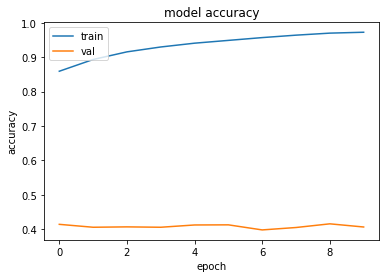

In [17]:
from matplotlib import pyplot as plt
plt.plot(history.history['issue_accuracy'])
plt.plot(history.history['val_issue_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()